In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

import matplotlib.pyplot as plt

### Paths

In [2]:
ls data

FER-2013/ JAFFE/    KDEF/


In [3]:
kdef_dir = 'data/KDEF'
fer_train = 'data/FER-2013/train'
fer_test = 'data/FER-2013/test'

### Define transformations

In [4]:
transform = transforms.Compose([
    transforms.CenterCrop((600, 600)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

transform2 = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])



### Create dataset using ImageFolder

In [5]:
fer_train = datasets.ImageFolder(root=fer_train, transform=transform2)
fer_test = datasets.ImageFolder(root=fer_test, transform=transform2)

fer_dataset = ConcatDataset([fer_train, fer_test])
kdef_dataset = datasets.ImageFolder(root=kdef_dir, transform=transform)


dataset = ConcatDataset([kdef_dataset, fer_dataset])

In [6]:
fer_dataset[0][0].shape

torch.Size([1, 128, 128])

In [7]:
len(kdef_dataset)

2938

In [8]:
len(dataset)

38825

In [9]:
classes = kdef_dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
fer_train.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Split the data into train, val, test

In [11]:
# define sizes of train, val and test
train_size = int(0.7 * len(dataset))  # 70% for train
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # rest for testing

# splitting dataset into train, val, test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#### DataLoader for each part

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
(train_size, test_size, val_size)

(27177, 5825, 5823)

In [45]:
def show_img(loader):

    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,8))

    for i, image in enumerate(images[:5]):
        ax[i].imshow(image[0])
        ax[i].set_title(classes[labels[i]])
        ax[i].axis('off')
    

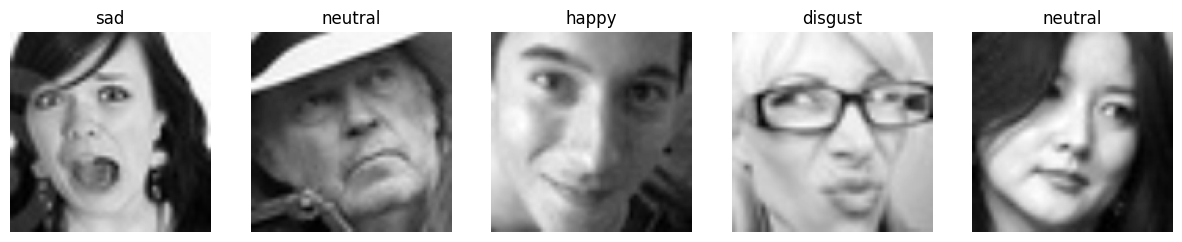

In [42]:
show_img(train_loader)

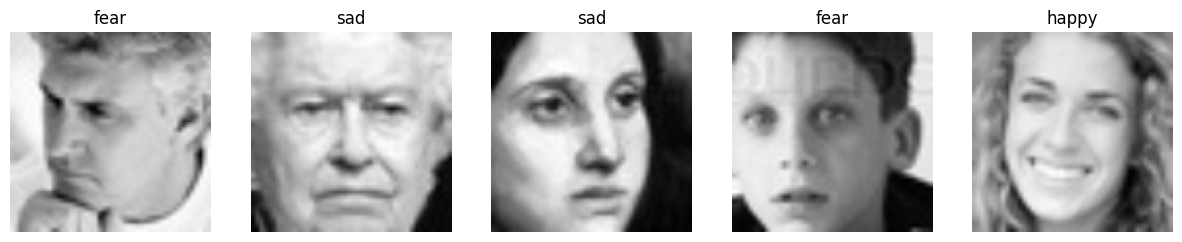

In [43]:
show_img(val_loader)

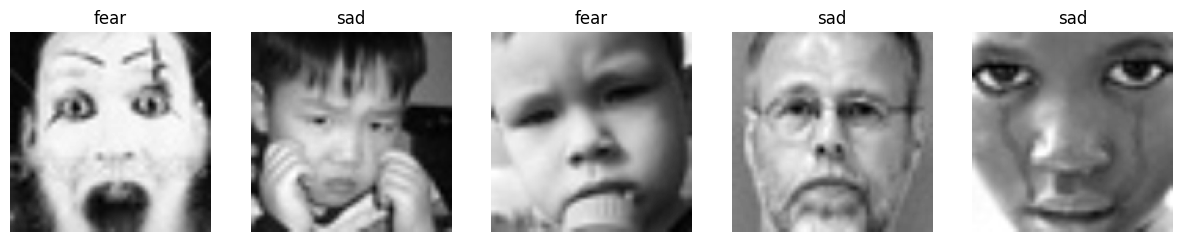

In [44]:
show_img(test_loader)

In [48]:
from collections import Counter


# Get the class indices for each image in the dataset
class_counts = Counter([label for _, label in dataset])

# Get the class names from the dataset
class_names = fer_train.classes

# Print the class balance
for class_idx, count in class_counts.items():
    print(f"Class '{class_names[class_idx]}': {count} images")


Class 'angry': 5373 images
Class 'disgust': 967 images
Class 'fear': 5541 images
Class 'happy': 9409 images
Class 'neutral': 6618 images
Class 'sad': 6496 images
Class 'surprise': 4421 images


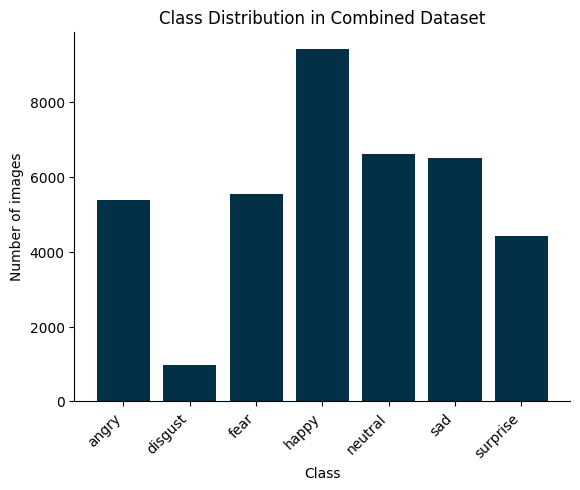

In [49]:
fig, ax = plt.subplots()
ax.bar(class_names, class_counts.values(), color='#023047')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Class Distribution in Combined Dataset')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right')
ax.spines[['top','right']].set_visible(False)
plt.show()


In [50]:
for batch in train_loader:
    inputs, target = batch
    break

In [51]:
target

tensor([4, 0, 0, 3, 6, 4, 3, 5, 4, 4, 4, 6, 0, 6, 0, 4, 4, 5, 2, 3, 4, 6, 4, 5,
        5, 3, 5, 3, 2, 4, 6, 3])

In [52]:
inputs[0].shape

torch.Size([1, 128, 128])

### Model creation


In [14]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [15]:
device

device(type='mps')

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognitionCNN(nn.Module):
    def __init__(self, num_classes=7):  
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
       
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
       
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        
        x = x.view(x.size(0), -1)
        
       
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [56]:
model = EmotionRecognitionCNN(num_classes=7)
model.to(device)

EmotionRecognitionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [28]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    
    if torch.backends.mps.is_available():
        device = torch.device("mps")  
        print("Using Metal Performance Shaders (MPS) for training.")
    elif torch.cuda.is_available():
        device = torch.device("cuda")          
        print("Using CUDA for training.")
    else:
        device = torch.device("cpu") 
        print("Using CPU for training.")

    
    model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
    
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

    
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()


            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

       

def evaluate_model(model, data_loader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            
            outputs = model(images)

         
            loss = criterion(outputs, labels)
            running_loss += loss.item()

           
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

   
    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [59]:
train_model(model, train_loader, val_loader,  num_epochs=10)


Using Metal Performance Shaders (MPS) for training.
Epoch [1/10] - Train Loss: 1.6460, Train Accuracy: 34.16%
Epoch [1/10] - Validation Loss: 1.4498, Validation Accuracy: 44.51%
Epoch [2/10] - Train Loss: 1.3889, Train Accuracy: 46.55%
Epoch [2/10] - Validation Loss: 1.3005, Validation Accuracy: 50.08%
Epoch [3/10] - Train Loss: 1.2434, Train Accuracy: 52.33%
Epoch [3/10] - Validation Loss: 1.2489, Validation Accuracy: 52.40%
Epoch [4/10] - Train Loss: 1.0925, Train Accuracy: 59.00%
Epoch [4/10] - Validation Loss: 1.2054, Validation Accuracy: 53.80%
Epoch [5/10] - Train Loss: 0.9541, Train Accuracy: 63.79%
Epoch [5/10] - Validation Loss: 1.2270, Validation Accuracy: 54.37%
Epoch [6/10] - Train Loss: 0.8185, Train Accuracy: 69.40%
Epoch [6/10] - Validation Loss: 1.2965, Validation Accuracy: 54.85%
Epoch [7/10] - Train Loss: 0.6915, Train Accuracy: 73.86%
Epoch [7/10] - Validation Loss: 1.3874, Validation Accuracy: 56.00%
Epoch [8/10] - Train Loss: 0.5806, Train Accuracy: 78.25%
Epoch [8

In [60]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.6586, Test Accuracy: 54.61%


### Model 2

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognitionCNN2(nn.Module):
    def __init__(self, num_classes=7):  
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  
        
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.fc1 = nn.Linear(512 * 2 * 2, 1024) 
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
       
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  
        x = self.pool(F.relu(self.conv5(x)))  
        x = self.pool(F.relu(self.conv6(x))) 
        
        
        x = x.view(x.size(0), -1)
        
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [62]:
model2 = EmotionRecognitionCNN2()

In [63]:
train_model(model2, train_loader, val_loader, num_epochs=10)

Using Metal Performance Shaders (MPS) for training.
Epoch [1/10] - Train Loss: 1.8430, Train Accuracy: 24.17%
Epoch [1/10] - Validation Loss: 1.8461, Validation Accuracy: 23.63%
Epoch [2/10] - Train Loss: 1.8368, Train Accuracy: 24.38%
Epoch [2/10] - Validation Loss: 1.8446, Validation Accuracy: 23.63%
Epoch [3/10] - Train Loss: 1.8364, Train Accuracy: 24.38%
Epoch [3/10] - Validation Loss: 1.8447, Validation Accuracy: 23.63%
Epoch [4/10] - Train Loss: 1.8361, Train Accuracy: 24.38%
Epoch [4/10] - Validation Loss: 1.8452, Validation Accuracy: 23.63%
Epoch [5/10] - Train Loss: 1.8362, Train Accuracy: 24.38%
Epoch [5/10] - Validation Loss: 1.8449, Validation Accuracy: 23.63%
Epoch [6/10] - Train Loss: 1.8356, Train Accuracy: 24.38%
Epoch [6/10] - Validation Loss: 1.8445, Validation Accuracy: 23.63%
Epoch [7/10] - Train Loss: 1.8356, Train Accuracy: 24.38%
Epoch [7/10] - Validation Loss: 1.8454, Validation Accuracy: 23.63%
Epoch [8/10] - Train Loss: 1.8353, Train Accuracy: 24.38%
Epoch [8

In [64]:
test_loss, test_accuracy = evaluate_model(model2, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f},\nTest Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.8322,
 Test Accuracy: 24.15%


### Model 3

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognitionCNN3(nn.Module):
    def __init__(self, num_classes=7): 
        super().__init__()
        
    
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)  
        
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)  
        
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc_bn1 = nn.BatchNorm1d(1024)  
        
        self.fc2 = nn.Linear(1024, 512)
        self.fc_bn2 = nn.BatchNorm1d(512)  
        
        self.fc3 = nn.Linear(512, num_classes)
        
    
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
    
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        
        
        x = x.view(x.size(0), -1)
        
        
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [ ]:
model3 = EmotionRecognitionCNN3()
train_model(model3, train_loader, val_loader, num_epochs=10)

Using Metal Performance Shaders (MPS) for training.


In [67]:
test_loss, test_accuracy = evaluate_model(model3, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f},\nTest Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.5583,
Test Accuracy: 62.54%


#### Data improvement

In [17]:
from torch.utils.data import WeightedRandomSampler


train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]


from collections import Counter
class_counts = Counter(train_labels)

а
class_weights = 1.0 / torch.tensor([class_counts[i] for i in range(len(class_counts))], dtype=torch.float)


sample_weights = [class_weights[label] for label in train_labels]


train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)


In [40]:
from collections import Counter

balanced_labels = []
for images, labels in train_loader:
    balanced_labels.extend(labels.numpy())

print(Counter(balanced_labels))

Counter({5: 3977, 2: 3940, 3: 3933, 0: 3926, 4: 3818, 1: 3800, 6: 3783})


In [21]:
model4 = EmotionRecognitionCNN3()
train_model(model4, train_loader, val_loader, num_epochs=10)

Using Metal Performance Shaders (MPS) for training.
Epoch [1/10] - Train Loss: 1.6493, Train Accuracy: 35.96%
Epoch [1/10] - Validation Loss: 1.4834, Validation Accuracy: 42.13%
Epoch [2/10] - Train Loss: 1.1800, Train Accuracy: 55.71%
Epoch [2/10] - Validation Loss: 1.2382, Validation Accuracy: 52.65%
Epoch [3/10] - Train Loss: 0.9842, Train Accuracy: 63.20%
Epoch [3/10] - Validation Loss: 1.2333, Validation Accuracy: 53.56%
Epoch [4/10] - Train Loss: 0.8319, Train Accuracy: 69.46%
Epoch [4/10] - Validation Loss: 1.2171, Validation Accuracy: 56.05%
Epoch [5/10] - Train Loss: 0.7062, Train Accuracy: 74.96%
Epoch [5/10] - Validation Loss: 1.1785, Validation Accuracy: 59.99%
Epoch [6/10] - Train Loss: 0.5671, Train Accuracy: 80.53%
Epoch [6/10] - Validation Loss: 1.1892, Validation Accuracy: 60.23%
Epoch [7/10] - Train Loss: 0.4580, Train Accuracy: 84.33%
Epoch [7/10] - Validation Loss: 1.2727, Validation Accuracy: 60.57%
Epoch [8/10] - Train Loss: 0.3678, Train Accuracy: 87.92%
Epoch [8

In [30]:
test_loss, test_accuracy = evaluate_model(model4, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f},\nTest Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.5473,
Test Accuracy: 60.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def analyze_model(model, test_loader, class_names, device):
    
    model.eval()
    true_labels = []
    predicted_labels = []

    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

   
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))

   
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, colorbar=True, ax=plt.gca())
    plt.xticks(rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

   
    print("\nTrue Labels (compact view):", true_labels[:10], "...", true_labels[-10:])
    print("Predicted Labels (compact view):", predicted_labels[:10], "...", predicted_labels[-10:])

    return


In [ ]:
analyze_model(model4, test_loader, class_names, device)

In [ ]:
##### no dropout

In [31]:
class EmotionRecognitionCNN4(nn.Module):
    def __init__(self, num_classes=7):  
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32) 
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128) 
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256) 
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512) 
        
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512) 
        
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc_bn1 = nn.BatchNorm1d(1024) 
        
        self.fc2 = nn.Linear(1024, 512)
        self.fc_bn2 = nn.BatchNorm1d(512) 
        
        self.fc3 = nn.Linear(512, num_classes)
        
        # Dropout
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        
        
        x = x.view(x.size(0), -1)
        
        
        x = F.relu(self.fc_bn1(self.fc1(x)))
        #x = self.dropout(x)
        x = F.relu(self.fc_bn2(self.fc2(x)))
        #x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [32]:
model5 = EmotionRecognitionCNN4()
train_model(model5, train_loader, val_loader, num_epochs=10)

Using Metal Performance Shaders (MPS) for training.
Epoch [1/10] - Train Loss: 1.5012, Train Accuracy: 42.40%
Epoch [1/10] - Validation Loss: 1.3120, Validation Accuracy: 49.17%
Epoch [2/10] - Train Loss: 1.0955, Train Accuracy: 58.51%
Epoch [2/10] - Validation Loss: 1.2049, Validation Accuracy: 54.27%
Epoch [3/10] - Train Loss: 0.9053, Train Accuracy: 66.20%
Epoch [3/10] - Validation Loss: 1.2559, Validation Accuracy: 55.06%
Epoch [4/10] - Train Loss: 0.7557, Train Accuracy: 72.37%
Epoch [4/10] - Validation Loss: 1.2136, Validation Accuracy: 59.28%
Epoch [5/10] - Train Loss: 0.6363, Train Accuracy: 77.41%
Epoch [5/10] - Validation Loss: 1.1549, Validation Accuracy: 60.93%
Epoch [6/10] - Train Loss: 0.4977, Train Accuracy: 82.58%
Epoch [6/10] - Validation Loss: 1.3495, Validation Accuracy: 57.70%
Epoch [7/10] - Train Loss: 0.3916, Train Accuracy: 86.96%
Epoch [7/10] - Validation Loss: 1.3175, Validation Accuracy: 61.55%
Epoch [8/10] - Train Loss: 0.3067, Train Accuracy: 89.87%
Epoch [8

In [33]:
test_loss, test_accuracy = evaluate_model(model5, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f},\nTest Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.5925,
Test Accuracy: 61.42%


In [ ]:
analyze_model(model5, test_loader, class_names, device)

In [38]:
model6 = EmotionRecognitionCNN4()
train_model(model6, train_loader, val_loader, num_epochs=10, lr=0.05)

Using Metal Performance Shaders (MPS) for training.
Epoch [1/10] - Train Loss: 1.5484, Train Accuracy: 40.29%
Epoch [1/10] - Validation Loss: 1.3980, Validation Accuracy: 47.95%
Epoch [2/10] - Train Loss: 1.1206, Train Accuracy: 57.93%
Epoch [2/10] - Validation Loss: 1.2426, Validation Accuracy: 52.41%
Epoch [3/10] - Train Loss: 0.9108, Train Accuracy: 66.10%
Epoch [3/10] - Validation Loss: 1.2758, Validation Accuracy: 54.44%
Epoch [4/10] - Train Loss: 0.7741, Train Accuracy: 71.52%
Epoch [4/10] - Validation Loss: 1.2038, Validation Accuracy: 57.56%
Epoch [5/10] - Train Loss: 0.6338, Train Accuracy: 77.27%
Epoch [5/10] - Validation Loss: 1.2123, Validation Accuracy: 58.85%
Epoch [6/10] - Train Loss: 0.5094, Train Accuracy: 82.42%
Epoch [6/10] - Validation Loss: 1.3270, Validation Accuracy: 59.11%
Epoch [7/10] - Train Loss: 0.3891, Train Accuracy: 86.81%
Epoch [7/10] - Validation Loss: 1.3380, Validation Accuracy: 61.17%
Epoch [8/10] - Train Loss: 0.3134, Train Accuracy: 89.41%
Epoch [8

In [39]:
test_loss, test_accuracy = evaluate_model(model6, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f},\nTest Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.7033,
Test Accuracy: 58.73%
